In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Uncomment if necessary
#from sklearn.preprocessing import OneHotEncoder
#from category_encoders import TargetEncoder
#from sklearn.preprocessing import MinMaxScaler, StandardScaler
#from scipy.stats.mstats import winsorize
import seaborn as sns
#from collections import Counter
#from sklearn.datasets import make_classification
#from imblearn.under_sampling import RandomUnderSampler
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [6]:
db = pd.read_csv('data/preprocessed.csv')

# Other possible preprocessed datasets
#db2 = pd.read_csv('data/preprocessed_normalized.csv')
#db3 = pd.read_csv('data/preprocessed_standardized.csv'
#db4 = pd.read_csv('data/preprocessed_noCapital.csv')
#db5 = pd.read_csv('data/preprocessed_noCapital_normalized.csv')
#db6 = pd.read_csv('data/preprocessed_noCapital_standardized.csv')

df = pd.DataFrame(db)

# Decision Trees

- Main advantage : Interpretability
- Main disadvantage : Might cause Overfitting

Explanations taken from https://scikit-learn.org/stable/modules/tree.html

Code partially taken from https://www.datacamp.com/tutorial/decision-tree-classification-python

#### Training and Accuracy

In [7]:
# Split target from features
X = df.drop('income', axis=1)
y = df['income']

In [8]:
# Create training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [9]:
# Train tree
clf = tree.DecisionTreeClassifier(random_state=26)
clf = clf.fit(X_train, y_train)

In [10]:
# Produce predictions using tree
y_pred_tree = clf.predict(X_test)

In [24]:
# Print accuracy
prediAccTree = metrics.accuracy_score(y_test, y_pred_tree)
print("Accuracy:", prediAccTree)

Accuracy: 0.7727272727272727


#### Impact of Hyperparameters on Accuracy

https://towardsdatascience.com/how-to-tune-a-decision-tree-f03721801680

Available Hyperparameters:

0. criterion (default "gini", or "entropy")
1. splitter (default "best", or "random")
2. max_depth (default "None", or an int below like 700)
3. min_samples_split (default "2", or an int below 40)
4. min_samples_leaf (default "1", or an int below 20)
5. min_weight_fraction_leaf (default "0", or a float up to 1)
6. max_features (default "None", or "auto"/"sqrt" or "log2" or an int below 13)
7. random_state (we should ignore that one and just set it to 42 or something)
8. min_impurity_decrease (default "0", I do not really understand it but I think we should leave it alone)
9. class_weight (default "None", too complex to change tbh)
10. presort (we should ignore this one)

In [8]:
# Function: Training tree with specific hyperparameters, and showing the accuracy gain
def treeWithHyperparams(**hp):
    hp["random_state"] = 26
    clf = tree.DecisionTreeClassifier(**hp)
    clf = clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    prediAccNew = metrics.accuracy_score(y_test, y_pred)
    improvement = prediAccNew - prediAccTree
    #print("Results using", list(hp.keys())[0], "=", list(hp.values())[0])
    print("Total accuracy:", prediAccNew)
    print("Accuracy gain:", improvement)

In [9]:
treeWithHyperparams(criterion='entropy')

Total accuracy: 0.765625
Accuracy gain: -0.007102272727272707


In [10]:
treeWithHyperparams(splitter='random')

Total accuracy: 0.7357954545454546
Accuracy gain: -0.03693181818181812


In [11]:
treeWithHyperparams(max_depth=5)

Total accuracy: 0.8309659090909091
Accuracy gain: 0.058238636363636354


In [12]:
treeWithHyperparams(min_samples_split=20)

Total accuracy: 0.7997159090909091
Accuracy gain: 0.026988636363636354


In [13]:
treeWithHyperparams(min_samples_leaf=20)

Total accuracy: 0.8082386363636364
Accuracy gain: 0.035511363636363646


In [14]:
treeWithHyperparams(min_weight_fraction_leaf=0.3)

Total accuracy: 0.7911931818181818
Accuracy gain: 0.01846590909090906


In [15]:
treeWithHyperparams(max_features='sqrt')

Total accuracy: 0.7514204545454546
Accuracy gain: -0.02130681818181812


In [16]:
treeWithHyperparams(max_features='log2')

Total accuracy: 0.7684659090909091
Accuracy gain: -0.0042613636363636465


We make the following observations concerning the individual hyperparameters:

0. Changing the criterion from gini to entropy seems useless
1. Changing the splitter from best to random seems useless
2. **Limiting the max depth to 5 improves performance**
3. **Setting the minimum split samples to 20 improves performance**
4. **Setting the minimum leaf samples to 20 improves performance**
5. Setting the minimum leaf weight fraction to 0.3 slightly improves performance
6. Limiting the max features seems useless

Our three most important hyperparameters are commonly used to combat overfitting.

This means that we can expect the best results if we reduce overfitting in our decision tree.

#### Confusion Matrix

- Precision
- Recall
- F1 score
- Accuracy

In [17]:
confMat_tree= metrics.confusion_matrix(y_test, y_pred_tree)
print(confMat_tree)

[[287  70]
 [ 90 257]]


In [18]:
TP_tree = confMat_tree[0][0]
FN_tree = confMat_tree[0][1]
FP_tree = confMat_tree[1][0]
TN_tree = confMat_tree[1][1]
precision_tree = TP_tree / TP_tree + FP_tree
recall_tree = TP_tree / TP_tree + FN_tree
F1score_tree = 2 * ((precision_tree * recall_tree) / (precision_tree + recall_tree))

In [19]:
print("Precision:", precision_tree)
print("Recall:", recall_tree)
print("F1-Score:", F1score_tree)

Precision: 91.0
Recall: 71.0
F1-Score: 79.76543209876543


The decision tree does not always identify people with an income above 50K.

However, if the model determines that somebody has an income above 50K, it is very likely correct.

# Bias Evaluation

In [57]:
from fairlearn.metrics import MetricFrame
from sklearn.metrics import accuracy_score

sensitive_features = ['race_White', 'race_Black', 'race_Amer-Indian-Eskimo', 'race_Asian-Pac-Islander','gender_Female','gender_Male']

mf = []

for feature in sensitive_features:
    sensitive_feature = X_test[feature]
    feature_mf = MetricFrame(accuracy_score, y_test, y_pred_tree, sensitive_features=sensitive_feature)
    mf.append(feature_mf)

# Print the combined MetricFrame
for i in mf:
    print(i.by_group)

race_White
0.0    0.76087
1.0    0.77451
Name: accuracy_score, dtype: float64
race_Black
0.0    0.776911
1.0    0.730159
Name: accuracy_score, dtype: float64
race_Amer-Indian-Eskimo
0.0    0.771429
1.0    1.000000
Name: accuracy_score, dtype: float64
race_Asian-Pac-Islander
0.0    0.774052
1.0    0.722222
Name: accuracy_score, dtype: float64
gender_Female
0.0    0.742126
1.0    0.852041
Name: accuracy_score, dtype: float64
gender_Male
0.0    0.852041
1.0    0.742126
Name: accuracy_score, dtype: float64


C:\Users\ricai\PycharmProjects\dsh\venv\lib\site-packages\fairlearn\metrics\_metric_frame.py:70: FutureWarning: You have provided 'metrics', 'y_true', 'y_pred' as positional arguments. Please pass them as keyword arguments. From version 0.10.0 passing them as positional arguments will result in an error.
  warnings.warn(
C:\Users\ricai\PycharmProjects\dsh\venv\lib\site-packages\fairlearn\metrics\_metric_frame.py:70: FutureWarning: You have provided 'metrics', 'y_true', 'y_pred' as positional arguments. Please pass them as keyword arguments. From version 0.10.0 passing them as positional arguments will result in an error.
  warnings.warn(
C:\Users\ricai\PycharmProjects\dsh\venv\lib\site-packages\fairlearn\metrics\_metric_frame.py:70: FutureWarning: You have provided 'metrics', 'y_true', 'y_pred' as positional arguments. Please pass them as keyword arguments. From version 0.10.0 passing them as positional arguments will result in an error.
  warnings.warn(
C:\Users\ricai\PycharmProjects\

In [58]:
from fairlearn.metrics import MetricFrame
from sklearn.metrics import confusion_matrix

# List of sensitive features
sensitive_features = ['race_White', 'race_Black', 'race_Amer-Indian-Eskimo', 'race_Asian-Pac-Islander', 'gender_Female', 'gender_Male']

# Function to calculate False Positive Rate
def false_positive_rate(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    fpr = fp / (fp + tn)
    return fpr

# Function to calculate False Negative Rate
def false_negative_rate(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    fnr = fn / (fn + tp)
    return fnr

# Iterate through each sensitive feature
for feature in sensitive_features:
    sensitive_feature = X_test[feature]
    
    # MetricFrame for False Positive Rate
    fpr_mf = MetricFrame(false_positive_rate, y_test, y_pred_tree, sensitive_features=sensitive_feature)
    print(f"False Positive Rate for {feature}:")
    print(fpr_mf.by_group)
    
    # MetricFrame for False Negative Rate
    fnr_mf = MetricFrame(false_negative_rate, y_test, y_pred_tree, sensitive_features=sensitive_feature)
    print(f"False Negative Rate for {feature}:")
    print(fnr_mf.by_group)

False Positive Rate for race_White:
race_White
0.0    0.148148
1.0    0.204620
Name: false_positive_rate, dtype: float64
False Negative Rate for race_White:
race_White
0.0    0.368421
1.0    0.245955
Name: false_negative_rate, dtype: float64
False Positive Rate for race_Black:
race_Black
0.0    0.206349
1.0    0.119048
Name: false_positive_rate, dtype: float64
False Negative Rate for race_Black:
race_Black
0.0    0.239264
1.0    0.571429
Name: false_negative_rate, dtype: float64
False Positive Rate for race_Amer-Indian-Eskimo:
race_Amer-Indian-Eskimo
0.0    0.196629
1.0    0.000000
Name: false_positive_rate, dtype: float64
False Negative Rate for race_Amer-Indian-Eskimo:
race_Amer-Indian-Eskimo
0.0    0.261628
1.0    0.000000
Name: false_negative_rate, dtype: float64
False Positive Rate for race_Asian-Pac-Islander:
race_Asian-Pac-Islander
0.0    0.191429
1.0    0.428571
Name: false_positive_rate, dtype: float64
False Negative Rate for race_Asian-Pac-Islander:
race_Asian-Pac-Islander
0.

C:\Users\ricai\PycharmProjects\dsh\venv\lib\site-packages\fairlearn\metrics\_metric_frame.py:70: FutureWarning: You have provided 'metrics', 'y_true', 'y_pred' as positional arguments. Please pass them as keyword arguments. From version 0.10.0 passing them as positional arguments will result in an error.
  warnings.warn(
C:\Users\ricai\PycharmProjects\dsh\venv\lib\site-packages\fairlearn\metrics\_metric_frame.py:70: FutureWarning: You have provided 'metrics', 'y_true', 'y_pred' as positional arguments. Please pass them as keyword arguments. From version 0.10.0 passing them as positional arguments will result in an error.
  warnings.warn(
C:\Users\ricai\PycharmProjects\dsh\venv\lib\site-packages\fairlearn\metrics\_metric_frame.py:70: FutureWarning: You have provided 'metrics', 'y_true', 'y_pred' as positional arguments. Please pass them as keyword arguments. From version 0.10.0 passing them as positional arguments will result in an error.
  warnings.warn(
C:\Users\ricai\PycharmProjects\

# Random Forest

- Main advantage :
- Main disadvantage :

#### Training and Accuracy

In [34]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
import pandas as pd

In [35]:

data = pd.read_csv('data\preprocessed.csv')

In [36]:
# Split the data into features and target variable
X = data.drop('income', axis=1)
y = data['income']

In [37]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)


In [42]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

# Random Forest
clf = RandomForestClassifier(random_state=26)

# Train the Random Forest classifier
clf.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = clf.predict(X_test)

# Evaluation Metrics
print("Random Forest - Evaluation Metrics:")
print(classification_report(y_test, y_pred_rf))

Random Forest - Evaluation Metrics:
              precision    recall  f1-score   support

           0       0.86      0.82      0.84       357
           1       0.83      0.87      0.85       347

    accuracy                           0.85       704
   macro avg       0.85      0.85      0.85       704
weighted avg       0.85      0.85      0.85       704



#### Impact of Hyperparameters on Accuracy

In [6]:
# Calculate confusion matrix
confusion_mat_rf = confusion_matrix(y_test, y_pred_rf)
print("Confusion Matrix:")
print(confusion_mat_rf)

# Calculate accuracy
accuracy_rf = (confusion_mat_rf[0, 0] + confusion_mat_rf[1, 1]) / sum(sum(confusion_mat_rf))
print("Accuracy:", accuracy_rf)

# Hyperparameter Tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

Confusion Matrix:
[[294  63]
 [ 46 301]]
Accuracy: 0.8451704545454546
Best Hyperparameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}


In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
# Function: Training Random Forest with specific hyperparameters, and showing the accuracy gain
def randomForestWithHyperparams(**hp):
    hp["random_state"] = 26
    clf = RandomForestClassifier(**hp)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    predAccNew = accuracy_score(y_test, y_pred)
    improvement = predAccNew - accuracy_rf
    print("Total accuracy:", predAccNew)
    print("Accuracy gain:", improvement)

# Call the randomForestWithHyperparams function with the best hyperparameters
randomForestWithHyperparams(**best_params)


Total accuracy: 0.8480113636363636
Accuracy gain: 0.0028409090909090606


#### Confusion Matrix

- Precision
- Recall
- F1 score
- Accuracy

In [8]:

best_clf = RandomForestClassifier(random_state=42, **best_params)
best_clf.fit(X_train, y_train)

y_pred_best = best_clf.predict(X_test)


print("Random Forest with Best Hyperparameters - Evaluation Metrics:")
print(classification_report(y_test, y_pred_best))


confusion_mat_best = confusion_matrix(y_test, y_pred_best)
print("Confusion Matrix with Best Hyperparameters:")
print(confusion_mat_best)

accuracy_best = (confusion_mat_best[0, 0] + confusion_mat_best[1, 1]) / sum(sum(confusion_mat_best))
print("Accuracy with Best Hyperparameters:", accuracy_best)

Random Forest with Best Hyperparameters - Evaluation Metrics:
              precision    recall  f1-score   support

           0       0.88      0.80      0.84       357
           1       0.81      0.89      0.85       347

    accuracy                           0.84       704
   macro avg       0.85      0.84      0.84       704
weighted avg       0.85      0.84      0.84       704

Confusion Matrix with Best Hyperparameters:
[[284  73]
 [ 37 310]]
Accuracy with Best Hyperparameters: 0.84375


In [9]:
from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred_best, output_dict=True)

precision = report['1']['precision']
recall = report['1']['recall']
f1_score = report['1']['f1-score']

print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1_score)


Precision: 0.8093994778067886
Recall: 0.8933717579250721
F1-Score: 0.8493150684931507


# Bias Evaluation

In [43]:
from fairlearn.metrics import MetricFrame
from sklearn.metrics import accuracy_score

sensitive_features = ['race_White', 'race_Black', 'race_Amer-Indian-Eskimo', 'race_Asian-Pac-Islander','gender_Female','gender_Male']

mf = []

for feature in sensitive_features:
    sensitive_feature = X_test[feature]
    feature_mf = MetricFrame(accuracy_score, y_test, y_pred_tree, sensitive_features=sensitive_feature)
    mf.append(feature_mf)

# Print the combined MetricFrame
for i in mf:
    print(i.by_group)

race_White
0.0    0.76087
1.0    0.77451
Name: accuracy_score, dtype: float64
race_Black
0.0    0.776911
1.0    0.730159
Name: accuracy_score, dtype: float64
race_Amer-Indian-Eskimo
0.0    0.771429
1.0    1.000000
Name: accuracy_score, dtype: float64
race_Asian-Pac-Islander
0.0    0.774052
1.0    0.722222
Name: accuracy_score, dtype: float64
gender_Female
0.0    0.742126
1.0    0.852041
Name: accuracy_score, dtype: float64
gender_Male
0.0    0.852041
1.0    0.742126
Name: accuracy_score, dtype: float64


C:\Users\ricai\PycharmProjects\dsh\venv\lib\site-packages\fairlearn\metrics\_metric_frame.py:70: FutureWarning: You have provided 'metrics', 'y_true', 'y_pred' as positional arguments. Please pass them as keyword arguments. From version 0.10.0 passing them as positional arguments will result in an error.
  warnings.warn(
C:\Users\ricai\PycharmProjects\dsh\venv\lib\site-packages\fairlearn\metrics\_metric_frame.py:70: FutureWarning: You have provided 'metrics', 'y_true', 'y_pred' as positional arguments. Please pass them as keyword arguments. From version 0.10.0 passing them as positional arguments will result in an error.
  warnings.warn(
C:\Users\ricai\PycharmProjects\dsh\venv\lib\site-packages\fairlearn\metrics\_metric_frame.py:70: FutureWarning: You have provided 'metrics', 'y_true', 'y_pred' as positional arguments. Please pass them as keyword arguments. From version 0.10.0 passing them as positional arguments will result in an error.
  warnings.warn(
C:\Users\ricai\PycharmProjects\

In [59]:
from fairlearn.metrics import MetricFrame
from sklearn.metrics import confusion_matrix

# List of sensitive features
sensitive_features = ['race_White', 'race_Black', 'race_Amer-Indian-Eskimo', 'race_Asian-Pac-Islander', 'gender_Female', 'gender_Male']

# Function to calculate False Positive Rate
def false_positive_rate(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    fpr = fp / (fp + tn)
    return fpr

# Function to calculate False Negative Rate
def false_negative_rate(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    fnr = fn / (fn + tp)
    return fnr

# Iterate through each sensitive feature
for feature in sensitive_features:
    sensitive_feature = X_test[feature]
    
    # MetricFrame for False Positive Rate
    fpr_mf = MetricFrame(false_positive_rate, y_test, y_pred_tree, sensitive_features=sensitive_feature)
    print(f"False Positive Rate for {feature}:")
    print(fpr_mf.by_group)
    
    # MetricFrame for False Negative Rate
    fnr_mf = MetricFrame(false_negative_rate, y_test, y_pred_tree, sensitive_features=sensitive_feature)
    print(f"False Negative Rate for {feature}:")
    print(fnr_mf.by_group)

False Positive Rate for race_White:
race_White
0.0    0.148148
1.0    0.204620
Name: false_positive_rate, dtype: float64
False Negative Rate for race_White:
race_White
0.0    0.368421
1.0    0.245955
Name: false_negative_rate, dtype: float64
False Positive Rate for race_Black:
race_Black
0.0    0.206349
1.0    0.119048
Name: false_positive_rate, dtype: float64
False Negative Rate for race_Black:
race_Black
0.0    0.239264
1.0    0.571429
Name: false_negative_rate, dtype: float64
False Positive Rate for race_Amer-Indian-Eskimo:
race_Amer-Indian-Eskimo
0.0    0.196629
1.0    0.000000
Name: false_positive_rate, dtype: float64
False Negative Rate for race_Amer-Indian-Eskimo:
race_Amer-Indian-Eskimo
0.0    0.261628
1.0    0.000000
Name: false_negative_rate, dtype: float64
False Positive Rate for race_Asian-Pac-Islander:
race_Asian-Pac-Islander
0.0    0.191429
1.0    0.428571
Name: false_positive_rate, dtype: float64
False Negative Rate for race_Asian-Pac-Islander:
race_Asian-Pac-Islander
0.

C:\Users\ricai\PycharmProjects\dsh\venv\lib\site-packages\fairlearn\metrics\_metric_frame.py:70: FutureWarning: You have provided 'metrics', 'y_true', 'y_pred' as positional arguments. Please pass them as keyword arguments. From version 0.10.0 passing them as positional arguments will result in an error.
  warnings.warn(
C:\Users\ricai\PycharmProjects\dsh\venv\lib\site-packages\fairlearn\metrics\_metric_frame.py:70: FutureWarning: You have provided 'metrics', 'y_true', 'y_pred' as positional arguments. Please pass them as keyword arguments. From version 0.10.0 passing them as positional arguments will result in an error.
  warnings.warn(
C:\Users\ricai\PycharmProjects\dsh\venv\lib\site-packages\fairlearn\metrics\_metric_frame.py:70: FutureWarning: You have provided 'metrics', 'y_true', 'y_pred' as positional arguments. Please pass them as keyword arguments. From version 0.10.0 passing them as positional arguments will result in an error.
  warnings.warn(
C:\Users\ricai\PycharmProjects\

# Some neural network algorithm

- Main advantage :
- Main disadvantage :

#### Training and Accuracy

In [94]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Activation, Dropout
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import TensorBoard

def load_split_csv_dataset(csv_file, split_ratio):
    # Load the CSV file
    dataset = pd.read_csv(csv_file)

    # Shuffle the dataset
    dataset = dataset.sample(frac=1).reset_index(drop=True)

    # Split features and target
    x = dataset.iloc[:, :-1].values
    y = dataset.iloc[:, -1:].values

    # Determine the split point based on the split ratio
    split_point = int(len(dataset) * split_ratio)

    # Split the dataset into two parts
    x_train = x[:split_point]
    y_train = y[:split_point]
    x_eval = x[split_point:]
    y_eval = y[split_point:]

    # Convert to numpy array and ensure it's float
    x_train = np.array(x_train).astype(float)
    y_train = np.array(y_train).astype(float)
    x_eval = np.array(x_eval).astype(float)
    y_eval = np.array(y_eval).astype(float)

    return x_train, y_train, x_eval, y_eval

X,y,X_val,y_val = load_split_csv_dataset("data/preprocessed_adult.csv",0.5)

n_layers = [2] #[2,1,3]
n_nodes = [256] #[256,512,1024]
learning_rates = [0.000001] #[0.000001,0.0001,]

for n_layer in n_layers:
	for n_node in n_nodes:
		for lr in learning_rates:

			model = Sequential()
			model.add(Flatten())

			for _ in range(n_layer):
				model.add(Dense(n_node))
				model.add(Activation('tanh'))
				model.add(Dropout(0.1))

			model.add(Dense(1))
			model.add(Activation('sigmoid'))

			opt = optimizers.Adam(lr = lr)

			model.compile(optimizer = opt, loss = 'mean_squared_error', metrics = ['accuracy'])

			model.fit(X, y, epochs = 200, batch_size = 32, validation_data = (X_val, y_val))
			print(model.evaluate(X_val, y_val))

Epoch 1/200
79/79 [==============================] - 1s 5ms/step - loss: 0.1372 - accuracy: 0.7967 - val_loss: 0.1181 - val_accuracy: 0.8300
Epoch 2/200
79/79 [==============================] - 0s 6ms/step - loss: 0.1182 - accuracy: 0.8175 - val_loss: 0.1132 - val_accuracy: 0.8320
Epoch 3/200
79/79 [==============================] - 0s 4ms/step - loss: 0.1156 - accuracy: 0.8275 - val_loss: 0.1224 - val_accuracy: 0.8192
Epoch 4/200
79/79 [==============================] - 0s 4ms/step - loss: 0.1141 - accuracy: 0.8327 - val_loss: 0.1106 - val_accuracy: 0.8376
Epoch 5/200
79/79 [==============================] - 0s 3ms/step - loss: 0.1118 - accuracy: 0.8355 - val_loss: 0.1094 - val_accuracy: 0.8416
Epoch 6/200
79/79 [==============================] - 0s 4ms/step - loss: 0.1096 - accuracy: 0.8399 - val_loss: 0.1090 - val_accuracy: 0.8452
Epoch 7/200
79/79 [==============================] - 0s 3ms/step - loss: 0.1092 - accuracy: 0.8479 - val_loss: 0.1099 - val_accuracy: 0.8440
Epoch 8/200
7

#### Impact of Hyperparameters on Accuracy

In [95]:
#A very slow learning rate coupled with with a high number of epochs allowed us to achieve very high accuracy


n_layers = 2
n_nodes = 256 #, or 512
learning_rates = 0.000001 #,0.0001
epochs = 200

#### Confusion Matrix

- Precision
- Recall
- F1 score
- Accuracy

79/79 [==============================] - 0s 935us/step


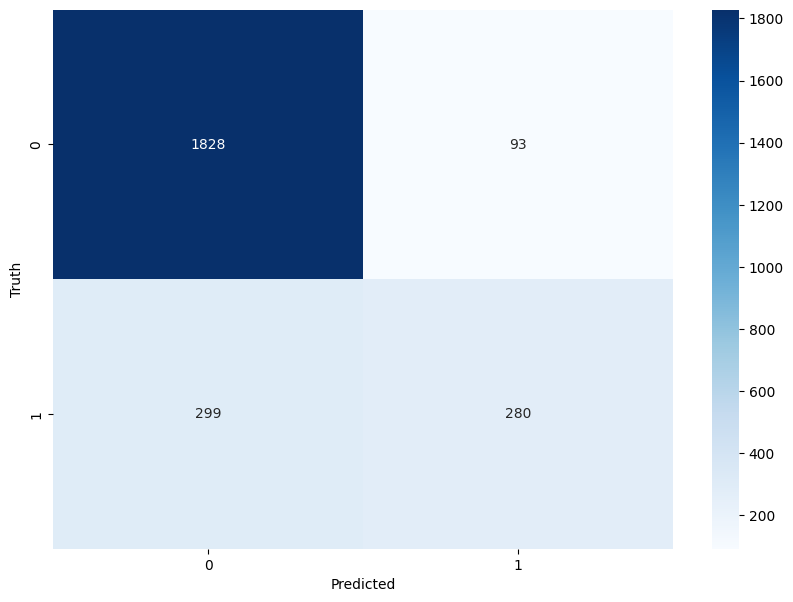

In [85]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

predictions = (model.predict(X_val) > 0.5).astype("int32")

# Compute confusion matrix
cm = confusion_matrix(y_val, predictions)

# Visualizing the confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [93]:
from fairlearn.metrics import MetricFrame
from sklearn.metrics import accuracy_score

# Convert back to the original categories
race_val = (X_val[:,-2]>0.5).astype('int')
gender_val = (X_val[:,-1]>0.5).astype('int')

# Create a dictionary of sensitive features
sensitive_features = {'race': race_val, 'gender': gender_val}

# Define the function for calculating demographic parity
def demographic_parity_difference(y_true, y_pred, **kwargs):
    y_pred = (y_pred > 0.5).astype('int')
    return y_pred[y_true==1].mean() - y_pred[y_true==0].mean()

# Create a metric frame
metrics = {'accuracy': accuracy_score, 'demographic_parity_difference': demographic_parity_difference}
metric_frame = MetricFrame(metrics=metrics,
                           y_true=y_val,
                           y_pred=predictions,
                           sensitive_features=sensitive_features)

print(metric_frame.difference())


[0 1 1 ... 0 0 0]
[1 1 1 ... 1 1 1]


ValueError: Found input variables with inconsistent numbers of samples: [1172, 2500]

# Bias Evaluation

https://fairlearn.org/main/user_guide/assessment/common_fairness_metrics.html

#### Demographic parity

"Demographic parity is achieved when the probability of a certain prediction is not dependent on sensitive group membership".

Our data has "sensitive" features; Notably gender and race.